In [55]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from datetime import datetime
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torchvision.datasets import MNIST

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

# 1 - Implement VAE-GAN

In [57]:
latent_dim=100
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 28 * 28)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.drop = nn.Dropout(0.3)
        self.relu = nn.LeakyReLU(0.2)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        x = self.drop(self.relu(self.bn1(self.fc1(x))))
        x1=x
        x = self.drop(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x,x1

# 2 - Training on MNIST

In [58]:
timestamp = (datetime.now()).strftime("%y%m%d_%H%M%S")
output_path = os.path.join("output", 'GAN_'+timestamp)
if not os.path.exists(output_path):
    os.makedirs(output_path)

## 2.1 - Configuration 

In [59]:
epochs=200
lr=3e-3
alpha=0.01
gamma=50
batch_size = 64
beta_1=0.5
decay=lr/epochs

## 2.2 - Load MNIST

In [60]:
print("[INFO] loading MNIST dataset...")
# Define a transform to normalize the data to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
# Filter the training and test datasets to include only images with label 2
train_filter = train_dataset.targets == 2
test_filter = test_dataset.targets == 2
train_images = train_dataset.data[train_filter]
test_images = test_dataset.data[test_filter]
# Concatenate the training and test datasets
filtered_images = torch.cat([train_dataset.data, test_dataset.data])
# Expand dimensions to add the channel dimension and normalize
filtered_images = train_images.unsqueeze(1).float()  # Add channel dimension and convert to float
# Create a TensorDataset from the filtered images

train_loader = torch.utils.data.DataLoader(filtered_images, batch_size=batch_size, shuffle=True)
real_batch = next(iter(train_loader))

[INFO] loading MNIST dataset...


## 2.3 Initialize GAN

GENERATOR

In [61]:
gen=Generator().to(device)
gen.apply(weights_init)
summary(gen,(latent_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
            Linear-4                 [-1, 2048]       1,050,624
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7                  [-1, 784]       1,606,416
              Tanh-8                  [-1, 784]               0
Total params: 2,713,872
Trainable params: 2,713,872
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 10.35
Estimated Total Size (MB): 10.42
----------------------------------------------------------------


DISCRIMINATOR

In [62]:
discrim=Discriminator().to(device)
gen.apply(weights_init)
summary(discrim,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
       BatchNorm1d-2                  [-1, 512]           1,024
         LeakyReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
         LeakyReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 1]             129
           Sigmoid-9                    [-1, 1]               0
Total params: 468,737
Trainable params: 468,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.81
-------------------------------------------

LOSS functions & Optimizers

In [63]:
# Loss and optimizers
criterion = nn.BCELoss().to(device)
optim_Gen = torch.optim.Adam(gen.parameters(), lr=lr)
optim_Dis = torch.optim.Adam(discrim.parameters(), lr=lr*alpha)

## 2.4 - Training

In [64]:
# Fixed noise for evaluation
noise_fixed = Variable(torch.randn((64, latent_dim))).to(device)
real_fixed = Variable(real_batch).to(device)
best_dis_loss = float('inf')

gan_loss_list, gen_loss_list, dis_loss_list = [], [], []
dis_real_list, dis_fake_list = [], []

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        bs = data.size()[0]
        
        # Create labels 
        ones_label = Variable(torch.full((bs, 1),1.0)).to(device)
        zeros_label = Variable(torch.full((bs, 1),0.0)).to(device)
        
        real_img = Variable(data).to(device)
        noise = Variable(torch.randn(bs, latent_dim)).to(device)
        gen_img = gen(noise)
    
        # Discriminator loss
        output_real = discrim(real_img)[0]
        errD_real = criterion(output_real, ones_label*0.9)  #label smoothing to prevent discriminator becomes too confident with real images
        dis_real_list.append(errD_real.item())

        output_fake = discrim(gen_img)[0]
        errD_rec_enc = criterion(output_fake, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())

        dis_loss = (errD_real + errD_rec_enc)#
      
        # Generator loss
        output_r = discrim(real_img)[1]
        output_f = discrim(gen_img)[1]
        gen_loss = F.mse_loss(output_r, output_f)

        optim_Dis.zero_grad()
        optim_Gen.zero_grad()
        dis_loss.backward(retain_graph=True)
        gen_loss.backward()
        optim_Dis.step()
        optim_Gen.step()

        gen_loss_list.append(gen_loss.item())
        dis_loss_list.append(dis_loss.item())
        gan_loss_list.append(gen_loss.item()+dis_loss.item())
        
        if i == len(train_loader)-1:
            print('[%03d/%d][%d/%d]    Loss_gan: %.4f    Loss_gen: %.4f    Loss_dis: %.4f    dis_real_loss: %.4f    dis_fake_loss: %.4f'
                  % (epoch+1, epochs, i+1, len(train_loader),
                     gen_loss.item()+dis_loss.item(), gen_loss.item(), dis_loss.item(), errD_real.item(), errD_rec_enc.item()))

            # Save images
            if (epoch == 0) or ((epoch+1)%(epochs/10) == 0):
                images = gen(noise_fixed).cpu().detach().numpy()
                images = (images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])
                fig, axes = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axes.flat):
                    ax.imshow(images[i].transpose((1, 2, 0)), cmap='gray')
                    ax.axis('off')
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                plt.savefig(os.path.join(output_path, f'epoch_{epoch + 1}_output.png'), bbox_inches='tight', pad_inches=0.1)
                plt.close()
            
    # Save model if prior loss improves - choose prior loss for the generated image quality
    last_dis_loss = dis_loss_list[-1]
    if last_dis_loss < best_dis_loss:
        best_dis_loss = last_dis_loss
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'discrim_state_dict': discrim.state_dict(),
            'optim_Gen_state_dict': optim_Gen.state_dict(),
            'optim_Dis_state_dict': optim_Dis.state_dict(),
        }, os.path.join(output_path, 'GAN_best_model.pth'))

[001/200][94/94]    Loss_gan: 2.2015    Loss_gen: 1.1372    Loss_dis: 1.0643    dis_real_loss: 0.6633    dis_fake_loss: 0.4011
[002/200][94/94]    Loss_gan: 1.9749    Loss_gen: 1.1400    Loss_dis: 0.8350    dis_real_loss: 0.5352    dis_fake_loss: 0.2998
[003/200][94/94]    Loss_gan: 1.6629    Loss_gen: 1.0694    Loss_dis: 0.5934    dis_real_loss: 0.4118    dis_fake_loss: 0.1816
[004/200][94/94]    Loss_gan: 1.5958    Loss_gen: 1.0161    Loss_dis: 0.5797    dis_real_loss: 0.3913    dis_fake_loss: 0.1884
[005/200][94/94]    Loss_gan: 1.5818    Loss_gen: 1.0867    Loss_dis: 0.4950    dis_real_loss: 0.3572    dis_fake_loss: 0.1379
[006/200][94/94]    Loss_gan: 1.6644    Loss_gen: 1.0296    Loss_dis: 0.6348    dis_real_loss: 0.3552    dis_fake_loss: 0.2796
[007/200][94/94]    Loss_gan: 1.4515    Loss_gen: 1.0717    Loss_dis: 0.3798    dis_real_loss: 0.3472    dis_fake_loss: 0.0326
[008/200][94/94]    Loss_gan: 1.3733    Loss_gen: 0.8558    Loss_dis: 0.5175    dis_real_loss: 0.3705    dis_fa

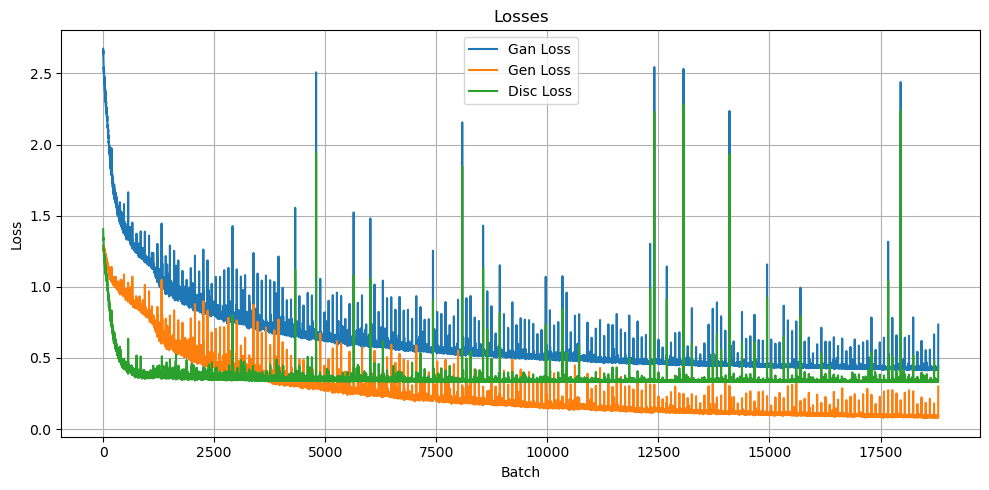

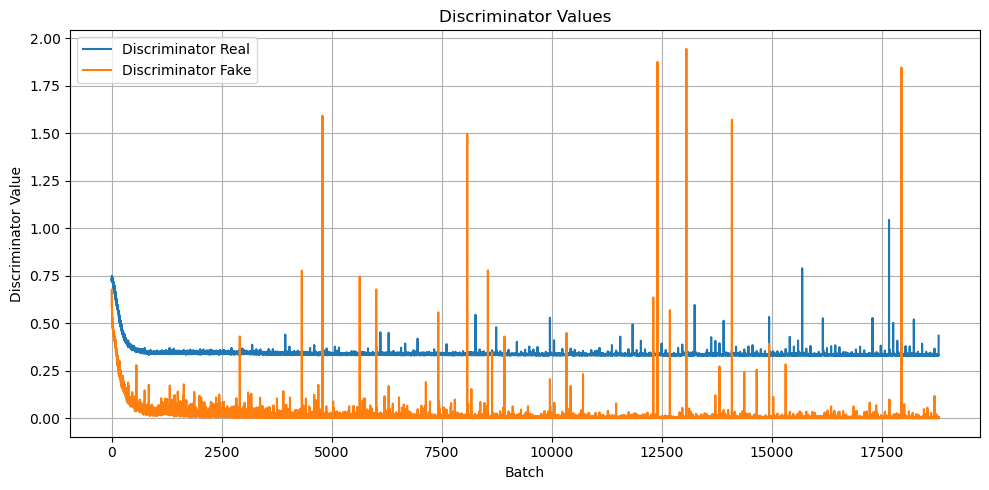

In [65]:
# First figure
plt.figure(figsize=(10, 5))
plt.plot(gan_loss_list, label='Gan Loss')
plt.plot(gen_loss_list, label='Gen Loss')
plt.plot(dis_loss_list, label='Disc Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_losses.png'))
plt.show()
plt.close()

# Second figure
plt.figure(figsize=(10, 5))
plt.plot(dis_real_list, label='Discriminator Real')
plt.plot(dis_fake_list, label='Discriminator Fake')
plt.xlabel('Batch')
plt.ylabel('Discriminator Value')
plt.title('Discriminator Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'plot_discriminator_values_.png'))
plt.show()
plt.close()

In [66]:
# Define the output file path
output_file_path = os.path.join(output_path, 'losses.txt') 

# Open the file in write mode
with open(output_file_path, 'w') as f:
    f.write("gan_loss_list: " + ', '.join(map(str, gan_loss_list)) + '\n')
    f.write("gen_loss_list: " + ', '.join(map(str, gen_loss_list)) + '\n')
    f.write("dis_loss_list: " + ', '.join(map(str, dis_loss_list)) + '\n')
    f.write("dis_real_list: " + ', '.join(map(str, dis_real_list)) + '\n')
    f.write("dis_fake_list: " + ', '.join(map(str, dis_fake_list)) + '\n')

print(f"Lists have been saved to {output_file_path}")

Lists have been saved to output\GAN_240713_025420\losses.txt


# 3 - Test on MNIST

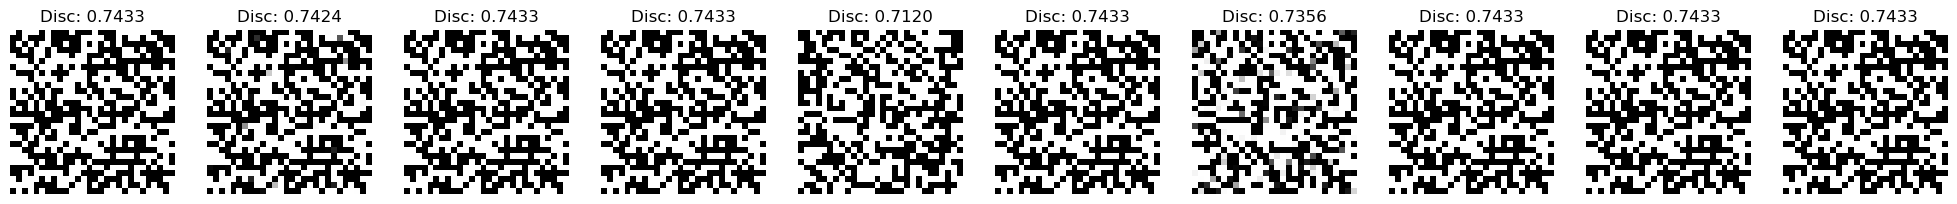

: 

In [67]:
# Load the saved model
checkpoint_path = os.path.join(output_path, 'GAN_best_model.pth')
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint['gen_state_dict'])
discrim.load_state_dict(checkpoint['discrim_state_dict'])
gen.eval()
discrim.eval()

# Generate 10 images
num_images = 10
z_fixed = torch.randn(num_images, latent_dim).to(device)  # Generate random latent vectors
with torch.no_grad():
    generated_images = gen(z_fixed)
    outputs = discrim(generated_images)[0]
generated_images = (generated_images * 0.5 + 0.5)    # Convert from [-1, 1] to [0, 1])

# Plot generated images
plt.figure(figsize=(2.5*num_images, 2.5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title(f"Disc: {outputs[i][0]:.4f}")
    plt.axis('off')
plt.show()

